We create truth sets based on the germline call set of NA12889, of NA12890, of NA12891, and of NA12892

## Classes of variants

Records in a VCF can be classified in several ways.  See the EXPRESSIONS section in [bcftools' manual](https://samtools.github.io/bcftools/bcftools.html).

1. variant types
    * snps
    * indels
    * mnps (multiple nucleotide polymorphisms), e.g: AAC -> AGC
    * ref (?)
    * bnd (?)
    * other
2. number of alternative alleles
    * biallelic, e.g: A -> C
    * multiallelic, e.g: A -> C,T
3. genotypes (GT)
    * AA: homozygous for alternative allele
    * RA: heterozygous
    * RR: homozygous for reference allele; strangely, such records do exist in our callsets
    * missing GT
    * R or A: sometimes the variant genotype is given as if humans were haploid

In [89]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
#matplotlib.rcParams['figure.figsize'] = [7, 5]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [94]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

## Number of variants

We will take the Illumina callset for NA12889 assuming it is representative for the callsets for all other CEPH/Utah grandparents, produced by Illumina or us. 

In [129]:
def count_records(filter_expr='', only_biallelic=True):
    '''
    Count records filtered by type
    
    The Python pipe idiom was lifted from here:
    https://security.openstack.org/guidelines/dg_avoid-shell-true.html#correct
    '''
    biall_filter = []
    if only_biallelic:
        biall_filter = ['-m', '2', '-M', '2']
    vcf_path = '/big/data/platinum-genomes/ceph-utah-vars/illumina-calls/S1/NA12889_S1.vcf.gz'
    args1 = ['bcftools', 'view', '-H', '-i'] + [filter_expr] + biall_filter + [vcf_path]
    args2 = ['wc', '-l']
    proc1 = subprocess.Popen(args1, shell=False, stdout=subprocess.PIPE)
    proc2 = subprocess.Popen(args2, shell=False, stdout=subprocess.PIPE, stdin=proc1.stdout)
    proc1.stdout.close()
    res = proc2.communicate()[0]
    res = int(res) # turn bytesliteral (e.g. b'5226\n') to integer
    return(res)

### Variants in total: number of alternative alleles

Getting the total number of variants
* **all**: any number of alternative alleles
* **biallelic**: exactly one alternative allele

In [130]:
ntot = {'all': count_records(only_biallelic=False), 'biallelic': count_records(only_biallelic=True)}

The roughly 5 million records is consistent with [the expectation](https://ghr.nlm.nih.gov/primer/genomicresearch/snp) of 4-5 million SNPs in a human genome.

In [136]:
pd.DataFrame(ntot, index=['count'])

,all,biallelic
count,5005623,4953008


Importantly, there are so few non-biallelic (mono or multiallelic) variants that we can generously exclude them from all further considerations.

### Types


In [137]:
var_types = ['snp', 'indel', 'mnp', 'ref', 'bnd', 'other']
ntypes = {y: count_records('TYPE=' + '"' + y + '"') for y in var_types}

This plotter function will come handy.

In [153]:
def bar_plot(counts=ntypes, categs=var_types, title='Variants of different types in NA12889'):
    fig, ax = plt.subplots()
    ax.barh(categs, [counts[k] for k in categs])
    ax.set(title=title, xlabel='count')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

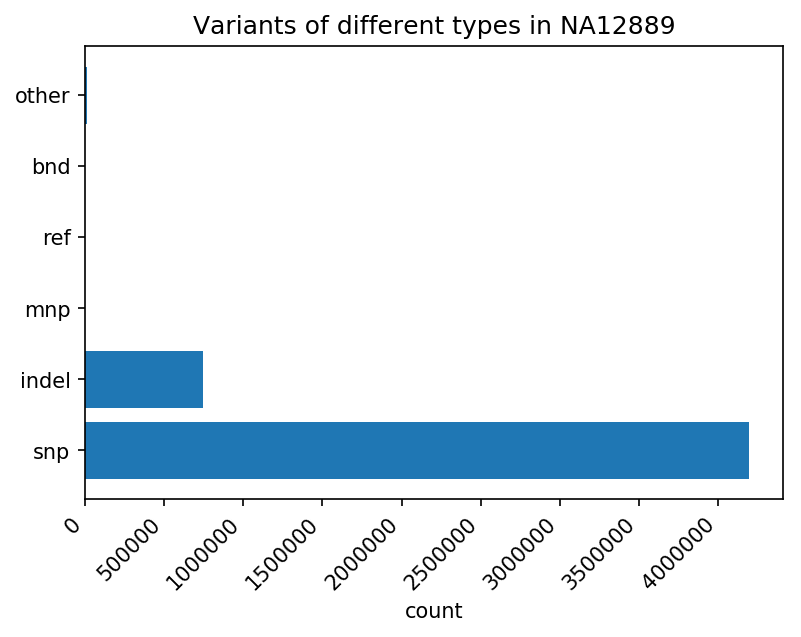

In [155]:
bar_plot(ntypes, var_types, 'Variants of different types in NA12889')

The records in all variant types add up to the total number of biallelic records calculated earlier.  Phew.

In [150]:
{'total': ntot['biallelic'], 'sum of types': sum(ntypes.values()), 'difference': ntot['biallelic'] - sum(ntypes.values())}

{'difference': 0, 'sum of types': 4953008, 'total': 4953008}

### Genotypes

In [151]:
genotypes = ['AA', 'RA', 'RR', 'hap', 'mis']
ngenotypes = {y: count_records('TYPE="snp" && GT=' + '"' + y + '"') for y in genotypes}

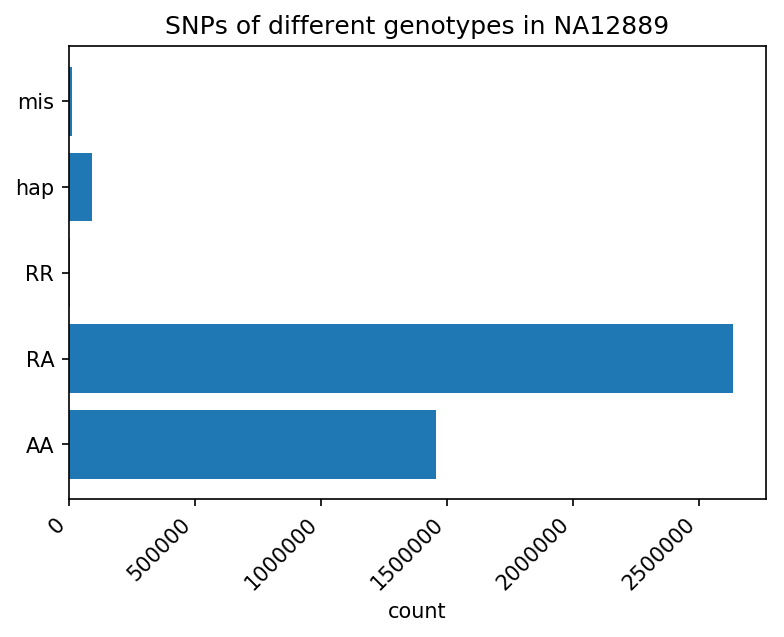

In [156]:
bar_plot(ngenotypes, genotypes, 'SNPs of different genotypes in NA12889')

In [157]:
genotypes = ['AA', 'RA', 'RR', 'hap', 'mis']
ngenotypes_indels = {y: count_records('TYPE="indel" && GT=' + '"' + y + '"') for y in genotypes}

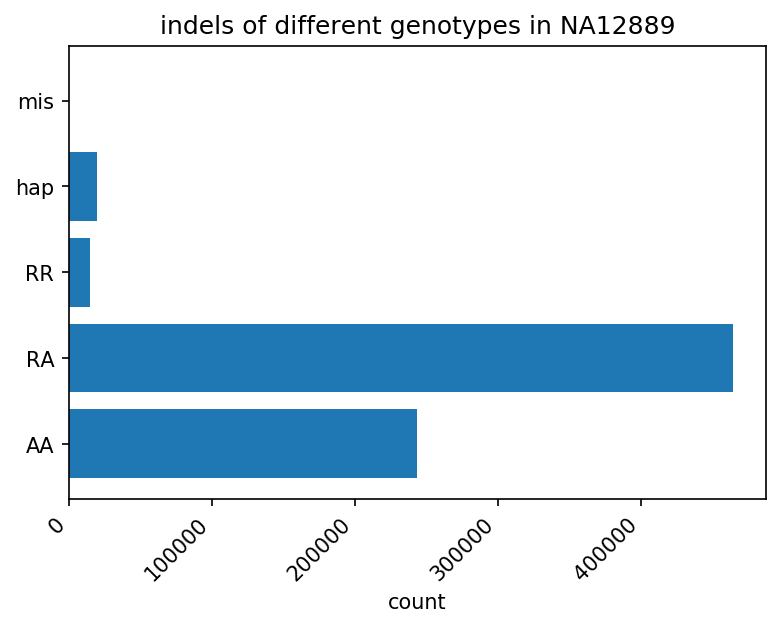

In [158]:
bar_plot(ngenotypes_indels, genotypes, 'indels of different genotypes in NA12889')